# Testcase Data Retrieval for Earthquake Swarms in the PNSN Network
This notebook provides a worked example of data retrieval for the following earthquake swarm within the PNSN network:  
The May 2017 earthquake swarm near Bremerton  
        - **Note** this example uses just 2 days of the swarm: May 10-11, 2017.  
        - Catalog searches show the swarm can broadly be defined between May 8 and November 2017  
        - ...potentially longer - a declustering analysis would better define this.  
![Event map of earthquakes in the seismic swarm near Bremerton, WA](data/2017-05_BRM/image.png)  


- "Earthquake swarm NE of Bremerton" blog post by Renate Hartog on May 11, 2017  
https://www.pnsn.org/blog/2017/05/11/earthquake-swarm-ne-of-bremerton


### Script Author
Nathan Stevens: ntsteven@uw.edu

In [7]:
# Import dependencies
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os


# Define small helper function - I know it's somewhere in ObsPy, but this was easier than hunting it down...
m2deg = lambda x:x/111139.

In [8]:
# Initialize Client
client = Client('IRIS')

### Data selection
Use the following fields to define an event and station query kwargs for use with the `obspy`
 - **starttime**: [obspy.UTCDateTime] Start time of query in UTC
 - **endtime**:      [obspy.UTCDateTime] End time of query in UTC
 - **latitude**:     [float] centroid latitude for queries in *degrees North*
 - **longitude**:    [float] centroid longitude for queries in *degrees East*
 - **maxradius**: [float] maximum radius for query in *degrees*

In [9]:
# Define fields for query
fields = ('starttime','endtime','latitude','longitude','maxradius')
TSstr = "2017-05-11T00:00:00"
TEstr = "2017-05-13T00:00:00"
# TEstr = "2017-05-12T23:59:59"
# Define data selection kwargs for events from IRIS catalog
qevent_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                UTCDateTime(TEstr),\
                                47.5828,-122.57841,m2deg(1e4)]))
# Define data selection kwargs for stations in IRIS catalog
qstation_kwargs = dict(zip(fields,[UTCDateTime(TSstr),\
                                   UTCDateTime(TEstr),\
                                47.5828,-122.57841,m2deg(30e3)]))

# Limit channels to those coming from broadbands ?H? and accelerometers ?N?
CLIST = 'HHZ,HHN,HH1,HHE,HH2,ENZ,EN1,ENN,EN2,ENE,BHZ,BHN,BHZ,EHZ,EH1,EHN,EH2,EHE'

qstation_kwargs['maxradius']

0.2699322470060015

In [10]:
# Download inventory with specified query down to channel 
# (ML generally operates on data w/o instrument response correction)
inv = client.get_stations(**qstation_kwargs,level='channel',channel=CLIST)#,channel='??[ZNE12]')
print(inv.networks[-1])

Network UW (Pacific Northwest Seismic Network (PNSN))
	Station Count: 30/860 (Selected/Total)
	1963-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (30):
			UW.BABE (Bainbridge, WA, USA)
			UW.BES3 (Bremerton Swarm Portable 3, WA, USA)
			UW.BES4 (Bremerton Swarm Portable 4, WA, USA)
			UW.BES5 (Bremerton Swarm Portable 5, WA, USA)
			UW.BRKS (Brookside, WA, USA)
			UW.BSFP (Boeing Fire Protection, WA, USA)
			UW.GMW (Gold Mountain, WA, USA)
			UW.GNW (Green Mountain, WA, USA)
			UW.GTWN (Georgetown Playfield ANSS-SMO)
			UW.HART (Harbor Island, Seattle, WA, USA)
			UW.HOLY (Holy Rosary ANSS-SMO)
			UW.KCAM (King County Airport Maintenance Shop, Seattle, WA, USA)
			UW.KDK (Kingdome, Seattle, WA, USA)
			UW.KIMB (Kimball School, Seattle, WA, USA)
			UW.KIMR (Kitsap County HHW Collection Facility, Bremerton, WA, USA)
			UW.KINR (North Road Shop, Poulsbo, WA, USA)
			UW.KITP (Kitsap Treatment Plant, WA, USA)
			UW.LAWT (Lawton, Seattle, WA, USA)
			UW.MNWA (Manchester, WA

In [11]:
# Download catalog from Client
cat = client.get_events(**qevent_kwargs,includearrivals=True,includeallmagnitudes=True,includeallorigins=True)
# print(cat.__str__(print_all=True))
print(cat.events[1])

Event:	2017-05-11T22:05:13.400000Z | +47.605, -122.549 | 1.58 Ml

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=10156882")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=22034754")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=179139698")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 2 Elements


In [12]:
# Load PNSN queried catalog data from custom queries for Bremerton-Adjacent Swarm (BRM)
df_BRM_full = pd.read_csv(os.path.join('data','2017-05_BRM','pnsn_event_catalog_2017_BRM_cluster.csv'),\
                          parse_dates=['Time UTC'],index_col='Time UTC')
# Sort by index
df_BRM_full = df_BRM_full.sort_index()
# Filter by query times
# Translate from obspy.UTCDateTime --> pandas.Timestamp
pdTS = pd.Timestamp(TSstr)
pdTE = pd.Timestamp(TEstr)

# Filter to period of interest
df_EVE = df_BRM_full[(df_BRM_full.index >= pdTS) & (df_BRM_full.index <= pdTE)]
print(len(df_EVE))
print(df_EVE)


19
                         Evid  Magnitude Magnitude Type    Epoch(UTC)  \
Time UTC                                                                
2017-05-11 00:41:03  61264902        1.0              l  1.494463e+09   
2017-05-11 01:49:33  61264912        0.3              d  1.494467e+09   
2017-05-11 02:31:17  61264922        1.5              l  1.494470e+09   
2017-05-11 07:35:24  61265017        3.5              l  1.494488e+09   
2017-05-11 07:40:44  61265022        1.0              l  1.494488e+09   
2017-05-11 07:41:13  60134708        0.3              d  1.494488e+09   
2017-05-11 08:19:37  61265037        1.3              l  1.494491e+09   
2017-05-11 08:37:57  61265047        1.5              l  1.494492e+09   
2017-05-11 09:00:56  61265062        1.1              l  1.494493e+09   
2017-05-11 09:04:43  61265067        0.8              l  1.494493e+09   
2017-05-11 09:19:09  61265072        2.1              l  1.494494e+09   
2017-05-11 09:27:40  61265077        1.1        

In [13]:
# Compile station locations 
sta_llh = []
for N_ in inv.networks:
    for S_ in N_.stations:
        sta_llh.append([N_.code,S_.code,S_.latitude,S_.longitude,S_.elevation])

df_STA = pd.DataFrame(sta_llh,columns=['network','station','latitude','longitude','elevation'])

print(df_STA)     

   network station   latitude   longitude  elevation
0       GM    AB13  47.618205 -122.287154      67.23
1       GM    AB14  47.612638 -122.290006     101.59
2       GM    AB15  47.614959 -122.300982      94.72
3       GM    AB16  47.615641 -122.295617      56.28
4       GM    AB17  47.612461 -122.303320      97.29
5       GS     WE2  47.574501 -122.384102     116.00
6       UW    BABE  47.605650 -122.536520      84.10
7       UW    BES3  47.642021 -122.525337      57.00
8       UW    BES4  47.642681 -122.646469      63.00
9       UW    BES5  47.584480 -122.568871       4.00
10      UW    BRKS  47.755196 -122.290131      23.00
11      UW    BSFP  47.531864 -122.307770       4.00
12      UW     GMW  47.548800 -122.785460     520.00
13      UW     GNW  47.564130 -122.824980     220.00
14      UW    GTWN  47.551212 -122.322006       9.00
15      UW    HART  47.583765 -122.350098       2.00
16      UW    HOLY  47.565400 -122.383600     106.00
17      UW    KCAM  47.544200 -122.318480     

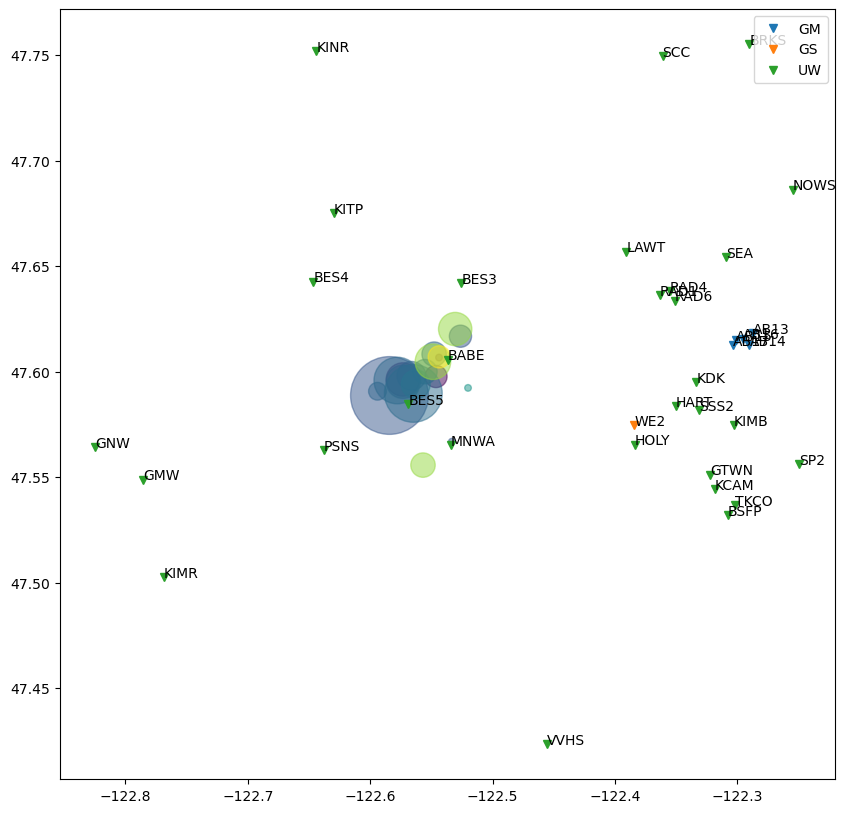

In [14]:
# Plot stations and events
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(df_EVE['Lon'],df_EVE['Lat'],c=df_EVE.index,s=(16*df_EVE['Magnitude'].values)**2,cmap='viridis',alpha=0.5)
for N_ in df_STA['network'].unique():
    ind = df_STA['network']==N_
    ax.plot(df_STA[ind]['longitude'],df_STA[ind]['latitude'],'v',ms=6,label=N_)

for i_ in range(len(df_STA)):
    ax.text(df_STA['longitude'].values[i_],df_STA['latitude'].values[i_],df_STA['station'].values[i_])
ax.legend()




In [22]:
plt.figure()
px.scatter_geo(df_STA,lon='longitude',lat='latitude',color='network')
plt.show()

<Figure size 640x480 with 0 Axes>

# Produce a file list for rsync from a PNW_store server
**Note** this must to be run in a separate terminal for security reasons  
Command formula for remote --files-from `rsync` call:  
`rsync -v --files-from=pnws_query.txt {USR}@{SERVER ADDRESS}:{PATH TO PNW{YEAR} CONTAINING DIR} {DESTINATION}`

In [23]:
q_fmtstr =  'PNW{YEAR}/{NET}/{YEAR}/{JD}/{STA}.{NET}.{YEAR}.{JD}'
qlist = []
with open('./data/2017-05_BRM/pnws_query.txt','w') as f_:
    for J_ in range(2):
        JD = UTCDateTime(TSstr).julday + J_
        for N_ in inv.networks:
            for S_ in N_.stations:
                iquery = q_fmtstr.format(HDD='wd07',STA=S_.code,NET=N_.code,YEAR=2017,JD=JD)
                qlist.append(iquery)
                f_.write(iquery+'\n')

f_.close()
qlist

['PNW2017/GM/2017/131/AB13.GM.2017.131',
 'PNW2017/GM/2017/131/AB14.GM.2017.131',
 'PNW2017/GM/2017/131/AB15.GM.2017.131',
 'PNW2017/GM/2017/131/AB16.GM.2017.131',
 'PNW2017/GM/2017/131/AB17.GM.2017.131',
 'PNW2017/GS/2017/131/WE2.GS.2017.131',
 'PNW2017/UW/2017/131/BABE.UW.2017.131',
 'PNW2017/UW/2017/131/BES3.UW.2017.131',
 'PNW2017/UW/2017/131/BES4.UW.2017.131',
 'PNW2017/UW/2017/131/BES5.UW.2017.131',
 'PNW2017/UW/2017/131/BRKS.UW.2017.131',
 'PNW2017/UW/2017/131/BSFP.UW.2017.131',
 'PNW2017/UW/2017/131/GMW.UW.2017.131',
 'PNW2017/UW/2017/131/GNW.UW.2017.131',
 'PNW2017/UW/2017/131/GTWN.UW.2017.131',
 'PNW2017/UW/2017/131/HART.UW.2017.131',
 'PNW2017/UW/2017/131/HOLY.UW.2017.131',
 'PNW2017/UW/2017/131/KCAM.UW.2017.131',
 'PNW2017/UW/2017/131/KDK.UW.2017.131',
 'PNW2017/UW/2017/131/KIMB.UW.2017.131',
 'PNW2017/UW/2017/131/KIMR.UW.2017.131',
 'PNW2017/UW/2017/131/KINR.UW.2017.131',
 'PNW2017/UW/2017/131/KITP.UW.2017.131',
 'PNW2017/UW/2017/131/LAWT.UW.2017.131',
 'PNW2017/UW/2017/13

### TRASH BEYOND HERE

In [ ]:
# # Get continuous waveforms using BULK request - this produces hole-y data
# ts = UTCDateTime(TSstr)
# te = ts + 3600.
# out_file_FMT = os.path.join('data','2017-05_BRM','{NET}','{STA}','{NET}.{STA}.{CP}.{TS}.{CHANS}.mseed')
# bulk = []         
# while ts < UTCDateTime(TEstr):
#     print('Running window %s -- %s'%(ts.isoformat(),te.isoformat()))
#     # Compose bulk request
#     bulk = []
#     for N_ in inv.networks:
#         for S_ in N_.stations:
#             try:
#                 os.makedirs(os.path.join('data','2017-05_BRM',N_.code,S_.code))
#             except:
#                 pass
#             for C_ in S_.channels:
#                 CC_ = C_.code
#                 LC_ = C_.location_code
#                 bulk.append((N_.code,S_.code,LC_,CC_,ts,te))
#     # Execute bulk request for chosen windowed timeframe for a given station
#     st = client.get_waveforms_bulk(bulk)

#     # Format and save waveforms in ML-compliant ordering - MSEED @ station level with Z,[N1],[E2] channel sequencing
#     for N_ in inv.networks:
#         for S_ in N_.stations:
#             sst = st.copy().select(network=N_.code,station=S_.code)
#             nchans = len(sst)

#             # If 3-C station, bundle data as normal
#             if nchans == 3:
#                 ist = Stream()
#                 ist += sst.select(channel='??Z')
#                 ist += sst.select(channel='??[N1]')
#                 ist += sst.select(channel='??[E1]')            
#                 CCODES = ist[0].stats.channel[-1] + ist[1].stats.channel[-1] + ist[2].stats.channel[-1]
#                 outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=sst[0].stats.channel[:2],CHANS=CCODES,TS=ts.isoformat())
#                 ist.write(outname,fmt='MSEED')
#             # If 1-C station, use the "trick" from Retailleau et al. (2022)
#             elif nchans == 1:
#                 ist = Stream()
#                 ist += sst[0]
#                 tr1f = sst[0].copy()
#                 tr1f.stats.channel+= 'N'  
#                 ist += tr1f
#                 tr2f = sst[0].copy()
#                 tr2f.stats.channel+= 'E'
#                 ist += tr2f
#                 CCODES = sst[0].stats.channel[-1] + 'ZZ'
#                 outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=sst[0].stats.channel[:2],CHANS=CCODES,TS=ts.isoformat())
#                 ist.write(outname,fmt='MSEED')
#             # Deal with multi-sensor/-sampling_rate stations
#             elif nchans > 3 and nchans%3 == 0:
#                 CPlist = []
#                 for C_ in S_.channels:
#                     if C_.code[:2] not in CPlist:
#                         CPlist.append(C_.code[:2])
#                 for CP_ in CPlist:
#                     ist = Stream()
#                     ist += sst.select(channel=CP_+'Z')
#                     ist += sst.select(channel=CP_+'[N1]')
#                     ist += sst.select(channel=CP_+'[E1]')            
#                     CCODES = ist[0].stats.channel[-1] + ist[1].stats.channel[-1] + ist[2].stats.channel[-1]
#                     outname = out_file_FMT.format(NET=N_.code,STA=S_.code,CP=CP_,CHANS=CCODES,TS=ts.isoformat())
#                     ist.write(outname,fmt='MSEED')
            
#     # Advance indices for WHILE loop
#     ts += 3600.
#     te += 3600.



In [ ]:
# # Use inventory to pull data for the period of interest and save to disk in 1 hour chunks
# ts = UTCDateTime(TSstr)
# te = ts + 3600.
# save_dir = os.path.join('data','2017-05_BRM')
# while ts < UTCDateTime(TEstr):
#     st = client.get_waveforms(starttime=ts,endtime=te)
#     ts += 3600.
#     te += 3600.


In [ ]:
# # Get continuous waveforms - OBSOLITED - This method fails to get extensive data
# ts = UTCDateTime(TSstr)
# te = ts + 3600.
# out_file_FMT = os.path.join('data','2017-05_BRM','{NET}','{STA}','{NET}.{STA}.{LOC}.{CHAN}.{TS}.mseed')
             
# while ts < UTCDateTime(TEstr):
#     print('Running window %s -- %s'%(ts.isoformat(),te.isoformat()))
#     for N_ in inv.networks:
#         # try:
#         #     os.makedirs(os.path.join('data','2017-05_BRM',str(N_.code)))
#         # except:
#         #     pass
#         for S_ in N_.stations:
#             st = Stream()
#             # try:
#             #     os.mkdir(os.path.join('data','2017-05_BRM',str(N_.code),str(S_.code)))
#             # except:
#             #     pass
#             for C_ in S_.channels:
#                 CC_ = C_.code
#                 LC_ = C_.location_code
#                 out_file = out_file_FMT.format(NET=N_.code,STA=S_.code,LOC=LC_,CHAN=CC_,TS=ts.isoformat())
#                 try:
#                     tr = client.get_waveforms(N_.code,S_.code,LC_,CC_,ts,te)[0]
#                     try: 
#                         os.mkdirs(os.path.join('data','2017-05_BRM',str(N_.code),str(S_.code)))
#                     except:
#                         pass
#                     tr.write(out_file,fmt='MSEED')
#                 except:
#                     pass
#     ts += 3600.
#     te += 3600.

In [ ]:
# # Use IRIS webservices / FDSN to query waveform data 
# # Based on mass_downloader example on docs.github.org: https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html
# domain = CircularDomain(**dict((k_,qstation_kwargs[k_]) for k_ in ['latitude','longitude','maxradius']),minradius=.0)

# restrictions = Restrictions(starttime=UTCDateTime(TSstr),endtime=UTCDateTime(TEstr),
#                             chunklength_in_sec=3600.)
#                             # limit_stations_to_inventory=inv,chunklength_in_sec=3600)
# mdl = MassDownloader()
# mdl.download(domain,restrictions,threads_per_client=2,\
#              mseed_storage=os.path.join('data','2017-05_BRM'),\
#              stationxml_storage=os.path.join('data','2017-05_BRM','{network}','{station}.xml'))

In [ ]:
# # Plot the catalog
# fig = plt.figure(figsize=(10,10))
# axa = fig.add_subplot(211)
# axa.plot(df_BRM_full['Magnitude'],'.')
# axa.set_xlabel('UTC Date Time')
# axa.set_ylabel('Magnitude (mixed methods)')
# axb = axa.twinx()
# axb.plot(df_BRM_full['Magnitude'].cumsum(),'r-',alpha=0.5)
# axb.set_ylabel('Cumulative magnitude',labelpad=15)

# # # Define window to assess
# # TS = pd.Timestamp("2017-05-11")
# # TE = pd.Timestamp("2017-05-13T00:00:00")

# axa.fill_between([TS,TE],[axa.get_ylim()[0]]*2,[axa.get_ylim()[1]]*2,color='yellow')


# axc = fig.add_subplot(212)
# IND = (df_BRM_full.index >= TS) & (df_BRM_full.index <= TE)
# axc.plot(df_BRM_full[IND]['Magnitude'],'.')
# axd = axc.twinx()
# axd.plot((10**df_BRM_full[IND]['Magnitude']).cumsum(),'r-',alpha=0.5)

# # axc = fig.add_subplot(223)
# # ch = axc.scatter(df_BRM_full['Lon'],df_BRM_full['Lat'],s = 5**df_BRM_full['Magnitude'],c=df_BRM_full.index)
# # plt.colorbar(ax=axc,cax=ch)